# Imports

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
# from pyvista import _vtk
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import pandas as pd
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns

#interactive plotting in separate window
# %matplotlib qt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
# %matplotlib qt

from mpl_toolkits import mplot3d
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_rgba_array
from matplotlib.figure import Figure
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

from copy import deepcopy

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
from IPython.lib.pretty import pretty, pprint
# from pretty import pprint

# Pandas display options
# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.width', 1000)


import rich as rich
# from rich import inspect
# from rich import print
# from rich import pretty

from PyQt5.QtWidgets import QApplication
import datetime as dt

import panel as pn
from panel.interact import interact, interactive, fixed, interact_manual
from panel import widgets
pn.extension()
# pn.extension('tabulator')



In [29]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
    importlib.reload(core)
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
# from neuropy.core.session.dataSession import SessionConfig, DataSessionLoader, DataSession, processDataSssion

# import neuropy.core as core
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.epoch import Epoch
from neuropy.core.epoch import NamedTimerange
from neuropy.core import Laps
from neuropy.core import Position
from neuropy.core import FlattenedSpiketrains
from neuropy.core import Neurons
from neuropy.utils.misc import print_seconds_human_readable
from neuropy.plotting import plot_raster
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.analyses.laps import estimate_laps, compute_laps_spike_indicies
from neuropy.analyses.pho_custom_placefields import PfND
from neuropy.plotting.placemaps import plot_all_placefields

In [30]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.plotting.laps import plot_laps_2d
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig
from PhoPositionalData.analysis.interactive_placeCell_config import print_subsession_neuron_differences

from PendingNotebookCode import debug_print_spike_counts, compute_placefields_as_needed, build_configs, build_units_colormap, build_placefield_multiplotter, process_by_good_placefields, estimation_session_laps, partition



# Load Session Data

In [7]:
# KDiba Old Format:
## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m
# From pre-computed .mat files:
# 07: 
basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'
# # ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'
sess = DataSessionLoader.kdiba_old_format_session(basedir)
active_sess_config = sess.config
session_name = sess.name

	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikes.mat...
done.
Failure loading .position.npy. Must recompute.

Computing linear positions for all active epochs for session...
curr_active_epoch_timeslice_indicies: Int64Index([   27,    28,    29,    30,    31,    32,    33,    34,    35,    36,
            ...
            52139, 52140, 52141, 52142, 52143, 52144, 52145, 52146, 52147, 52148], dtype='int64', length=52122)
 	 np.shape(curr_active_epoch_timeslice_indicies): (52122,)
curr_active_epoch_timeslice_indicies: Int64Index([52149, 52150, 52151, 52152, 52153, 52154, 52155, 52156, 52157, 52158,
            ...
            

In [8]:
# sess.spikes_df.size # (1014937, 18)
# np.sum(sess.neurons.n_spikes) # 1014937
print('session dataframe spikes: {}\nsession.neurons.n_spikes summed: {}\n'.format(sess.spikes_df.shape, np.sum(sess.neurons.n_spikes)))


session dataframe spikes: (932598, 20)
session.neurons.n_spikes summed: 932598



desc_crossings_x: (24,), asc_crossings_x: (24,)


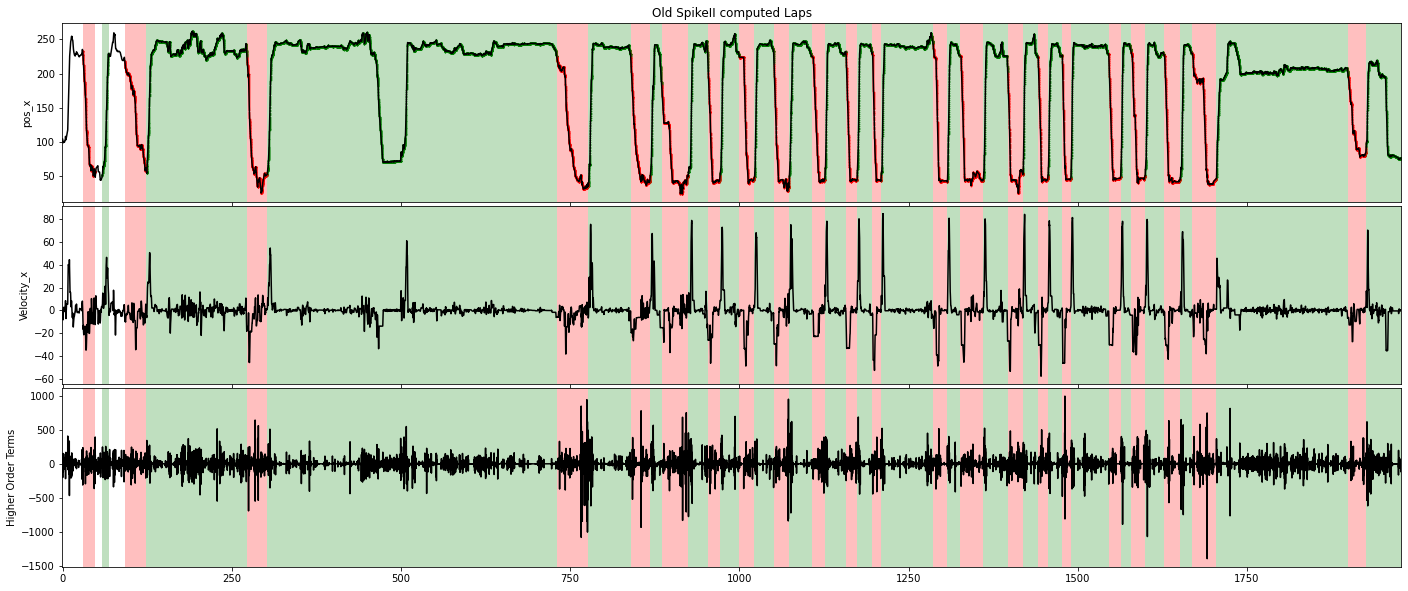

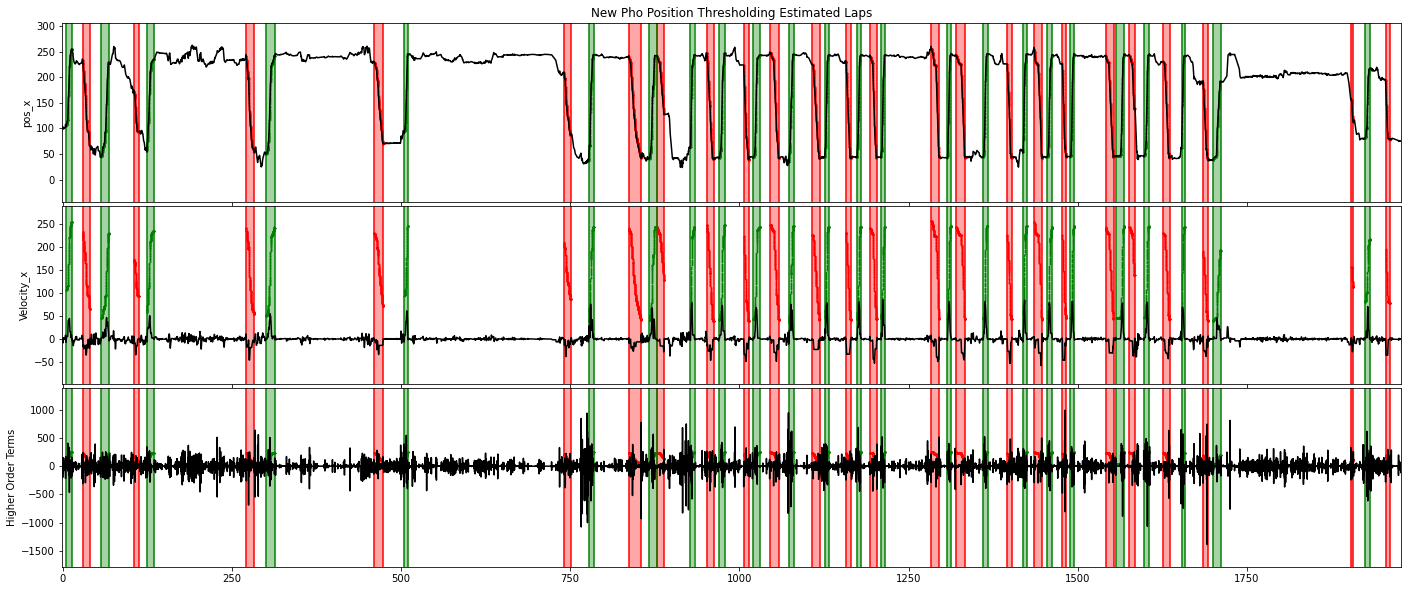

In [12]:
## Estimate the Session's Laps data using my algorithm from the loaded position data.
sess = estimation_session_laps(sess)
# plot_laps_2d(sess)

### Lap Specific Session Debugging



In [33]:
lap_specific_epochs = sess.laps.as_epoch_obj()
# lap_specific_epochs.to_dataframe()
any_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(len(sess.laps.lap_id))])
even_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(0, len(sess.laps.lap_id), 2)])
odd_lap_specific_epochs = lap_specific_epochs.label_slice(lap_specific_epochs.labels[np.arange(1, len(sess.laps.lap_id), 2)])

# rich.inspect(lap_specific_epochs)
# even_lap_specific_epochs
# lap_specific_epochs
# pretty(lap_specific_epochs)
# pprint(lap_specific_epochs)
# pretty(lap_specific_epochs)




# Filter Session by Epoch:

In [180]:
sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
# sess.epochs.to_dataframe()
# active_epoch = sess.epochs.get_named_timerange('maze1')
# print('active_epoch: {}'.format(active_epoch))
# active_epoch = sess.epochs.get_named_timerange('maze2')
active_epoch = NamedTimerange(name='maze', start_end_times=[sess.epochs['maze1'][0], sess.epochs['maze2'][1]])
active_subplots_shape = (1,1) # Single subplot
# active_subplots_shape = '1|2' # 1 subplot on left, two on right
active_config = build_configs(active_sess_config, active_epoch, active_subplots_shape = active_subplots_shape)

## All Spikes:
active_epoch_session = sess.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)
# print(sess.neurons.n_spikes)

# # ## Lap_specific Spikes Only:
# active_lap_specific_epoch_session = lap_specific_session.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
# print_subsession_neuron_differences(lap_specific_session.neurons, active_lap_specific_epoch_session.neurons)
# # print(active_lap_specific_epoch_session.neurons.n_spikes)

## Configure Placefield Calc:
should_display_2D_plots = False

# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=2, smooth=0.5, frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=10, smooth=0.5, frate_thresh=2.0) # works well
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=2.5, smooth=1.5, frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.5, 0.5), frate_thresh=0.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(3, 4), smooth=(2, 1), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 10), smooth=(0.5, 0.5), frate_thresh=2.0) ## Works well for 2D Placemaps
# height: 20.0
# width: 250.0
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0, grid_bin=(2.0, 0.2), smooth=(0.5, 0.5), frate_thresh=2.0) ## Extremely Slow
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0, grid_bin=(2.0, 1.0), smooth=(0.5, 0.5), frate_thresh=2.0) ## Very slow, doesn't work

# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.0, 0.0), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.1, 0.1), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(1.0, 10.0), frate_thresh=2.0)

# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(25, 9), smooth=(0.0, 0.0), frate_thresh=2.0)
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(5, 3), smooth=(0.0, 0.0), frate_thresh=2.0)


# active_config.computation_config.frate_thresh = 0.0

Constraining to units with type: pyramidal
Constraining to epoch with times (start: 22.26, end: 1932.4200048116618)
77726/932598 total spikes spanning 40/64 units remain in subsession


In [186]:
## position binning with _bin_pos_nD testing and validation:
from neuropy.analyses.pho_custom_placefields import _bin_pos_nD
# from neuropy.analyses.placefields import _bin_pos_nD

test_pos_x = active_epoch_session.position.x
test_pos_y = active_epoch_session.position.y

# test_bin_size = (5, 3)
test_bin_size = active_config.computation_config.grid_bin

test_xbin, test_ybin, test_bin_info = _bin_pos_nD(x=test_pos_x, y=test_pos_y, num_bins=None, bin_size=test_bin_size)
print(f'for bin_size: {test_bin_size} computed pos bins: {test_bin_info}') # for bin_size: (25, 9) computed pos bins: {'mode': 'bin_size', 'xstep': 25, 'xnum_bins': 11, 'ystep': 9, 'ynum_bins': 5}
# for bin_size: (5, 9) computed pos bins: {'mode': 'bin_size', 'xstep': 5, 'xnum_bins': 49, 'ystep': 9, 'ynum_bins': 5}
# for bin_size: (5, 3) computed pos bins: {'mode': 'bin_size', 'xstep': 5, 'xnum_bins': 49, 'ystep': 3, 'ynum_bins': 11}

assert test_bin_size[0] == test_bin_info['xstep'], "xstep calculation failure!"
assert test_bin_size[1] == test_bin_info['ystep'], "ystep calculation failure!"

# assert test_bin_size[0] == np.shape(test_xbin), "xstep calculation failure!"
# assert test_bin_size[1] == np.shape(test_ybin), "xstep calculation failure!"


for bin_size: (5, 3) computed pos bins: {'mode': 'bin_size', 'xstep': 5, 'xnum_bins': 49, 'ystep': 3, 'ynum_bins': 11}


## Compute Placefields if needed:

## Compute the placefields for lap-only filtered Session:

In [ ]:
def debug_print_ratemap(ratemap):
    # Get the cell IDs that have a good place field mapping:
    good_placefield_neuronIDs = np.array(ratemap.neuron_ids) # in order of ascending ID
    print('good_placefield_neuronIDs: {}; ({} good)'.format(good_placefield_neuronIDs, len(good_placefield_neuronIDs)))
    
def debug_print_placefield(active_epoch_placefield, short=True):
    # Get the cell IDs that have a good place field mapping:
    good_placefield_neuronIDs = np.array(active_epoch_placefield.ratemap.neuron_ids) # in order of ascending ID
    num_spikes_per_spiketrain = np.array([np.shape(a_spk_train)[0] for a_spk_train in active_epoch_placefield.spk_t])
    if short:
        print('good_placefield_neuronIDs: ({} good)'.format(len(good_placefield_neuronIDs)), end='\n')
        print('num_spikes: ({} total spikes)'.format(np.sum(num_spikes_per_spiketrain)), end='\n')
    else:
        print('good_placefield_neuronIDs: {}; ({} good)'.format(good_placefield_neuronIDs, len(good_placefield_neuronIDs)), end='\n')
        print('num_spikes: {}; ({} total spikes)'.format(num_spikes_per_spiketrain, np.sum(num_spikes_per_spiketrain)), end='\n')
    return pd.DataFrame({'neuronID':good_placefield_neuronIDs, 'num_spikes':num_spikes_per_spiketrain}).T


def compute_placefields_masked_by_epochs(sess, active_config, included_epochs=None, should_display_2D_plots=False):
    active_session = deepcopy(sess)
    active_epoch_placefields1D, active_epoch_placefields2D = compute_placefields_as_needed(active_session, active_config.computation_config, active_config, None, None, included_epochs=included_epochs, should_force_recompute_placefields=True, should_display_2D_plots=should_display_2D_plots)
    # Focus on the 2D placefields:
    # active_epoch_placefields = active_epoch_placefields2D
    # Get the updated session using the units that have good placefields
    # active_session, active_config, good_placefield_neuronIDs = process_by_good_placefields(active_session, active_config, active_epoch_placefields)
    # debug_print_spike_counts(active_session)
    return active_epoch_placefields1D, active_epoch_placefields2D


active_epoch_placefields1D, active_epoch_placefields2D = compute_placefields_masked_by_epochs(active_epoch_session, active_config, included_epochs=None, should_display_2D_plots=should_display_2D_plots)
even_lap_specific_placefields1D, even_lap_specific_placefields2D = compute_placefields_masked_by_epochs(active_epoch_session, active_config, included_epochs=even_lap_specific_epochs, should_display_2D_plots=should_display_2D_plots)
odd_lap_specific_placefields1D, odd_lap_specific_placefields2D = compute_placefields_masked_by_epochs(active_epoch_session, active_config, included_epochs=odd_lap_specific_epochs, should_display_2D_plots=should_display_2D_plots)
any_lap_specific_placefields1D, any_lap_specific_placefields2D = compute_placefields_masked_by_epochs(active_epoch_session, active_config, included_epochs=any_lap_specific_epochs, should_display_2D_plots=should_display_2D_plots)
# Compare the results
# debug_print_ratemap(active_epoch_placefields1D.ratemap)
# num_spikes_per_spiketrain = np.array([np.shape(a_spk_train)[0] for a_spk_train in active_epoch_placefields1D.spk_t])
# num_spikes_per_spiketrain
# print('placefield_neuronID_spikes: {}; ({} total spikes)'.format(num_spikes_per_spiketrain, np.sum(num_spikes_per_spiketrain)))
debug_print_placefield(active_epoch_placefields1D)
debug_print_placefield(any_lap_specific_placefields1D)
debug_print_placefield(even_lap_specific_placefields1D)
debug_print_placefield(odd_lap_specific_placefields1D)

In [189]:
active_epoch_placefields2D
# active_binwidths = (active_epoch_placefields2D.config.grid_bin[0], active_epoch_placefields2D.config.grid_bin[1]) # e.g. (2, .5)

print(active_epoch_placefields1D.config)
print(np.shape(active_epoch_placefields1D.occupancy)) # the 1D occupancy map is (48,) units wide

print(np.shape(active_epoch_placefields2D.occupancy)) # the 1D occupancy map is (48, 10). The Width is 10
# print(active_epoch_placefields2D.config)

active_epoch_placefields2D.occupancy[0,:] # occupancy appears to by 4 columns wide, and 10 rows tall. The value I passed in though was (25, 9)

<PlacefieldComputationParameters: {'speed_thresh': 0.0, 'grid_bin': (5, 3), 'smooth': (0.0, 0.0), 'frate_thresh': 2.0};>
(48,)
(48, 10)


array([0.06673393, 0.90090801, 0.56723837, 1.16784371, 0.90090801,
       0.56723837, 0.26693571, 0.26693571, 0.        , 0.        ])

active_binwidths: (5, 3)


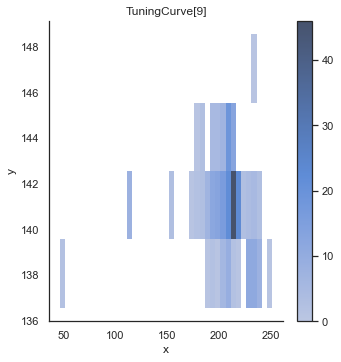

<Figure size 720x432 with 0 Axes>

In [190]:
from matplotlib.image import NonUniformImage
import seaborn as sns
# sns.set_theme(style="dark")
sns.set_theme(style="white")

active_ratemap = any_lap_specific_placefields2D.ratemap
curr_unit_idx = 3

def test_plot_ratemap(curr_unit_idx = 3):
    fig = Figure(figsize=(10, 6))
    
    plot_mode = 5
    active_binwidths = (any_lap_specific_placefields2D.config.grid_bin[0], any_lap_specific_placefields2D.config.grid_bin[1]) # e.g. (2, .5)
    
    print(f'active_binwidths: {active_binwidths}')
    pfmap = active_ratemap.tuning_curves[curr_unit_idx]
    curr_pfmap = np.array(pfmap)
    if plot_mode == 0:
        # ax = fig.subplots()
        ax = fig.add_subplot(111, title='pcolormesh test', aspect='equal')
        mesh_X, mesh_Y = np.meshgrid(active_ratemap.xbin, active_ratemap.ybin)
        curr_pfmap = np.rot90(np.fliplr(curr_pfmap)) / np.nanmax(curr_pfmap)
        ax.pcolormesh(mesh_X, mesh_Y, curr_pfmap, cmap='jet', vmin=0);
    
    
    elif plot_mode == 1:
        xedges = active_ratemap.xbin
        yedges = active_ratemap.ybin
        ax = fig.add_subplot(111, title='NonUniformImage Test', aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
        # print(f'curr_pfmap: {np.shape(curr_pfmap)}') # (6, 74)
        # print(f'curr_pfmap: {np.shape(curr_pfmap)}') # (6, 74)
        # print(f'curr_pfmap: {np.shape(curr_pfmap)}') # (6, 74)
        
        # rich.inspect(active_ratemap.xbin_centers) # xbin: (75,), ybin: (7,), xbin_centers: (74,), ybin_centers: (6,)
        im = NonUniformImage(ax, interpolation='bilinear') # interpolation='bilinear'
        xcenters = (xedges[:-1] + xedges[1:]) / 2
        ycenters = (yedges[:-1] + yedges[1:]) / 2
        im.set_data(xcenters, ycenters, curr_pfmap.T)
        # im.set_data(active_ratemap.xbin_centers, active_ratemap.ybin_centers, curr_pfmap.T)
        ax.images.append(im)
        
    elif plot_mode == 2:
        # g = sns.jointplot("s_zscore","p_zscore",s=2, data=scatter_all, kind="kde")
        scatter_all = np.array(any_lap_specific_placefields2D.spk_pos[curr_unit_idx]) # (2, 825)
        # any_lap_specific_placefields2D.occupancy
        scatter_all_df = pd.DataFrame({'x':scatter_all[0,:], 'y':scatter_all[1,:]})
        # g = sns.jointplot(x='x', y='y', data=scatter_all_df, kind="kde", marginal_ticks=True)
        # g = sns.jointplot(x='x', y='y', data=scatter_all_df)
        # g = sns.jointplot(x='x', y='y', data=scatter_all_df, kind="hex", marginal_ticks=True)
        # g = sns.jointplot(x='x', y='y', data=scatter_all_df, kind="hist", marginal_ticks=True)
        
        ax = plt.gca()
        sns.heatmap(curr_pfmap, annot=True, linewidths=.5, ax=ax)
        # sns.heatmap(curr_pfmap, annot=True, fmt="d", linewidths=.5, ax=ax)
        # , hue="species"
        
        # marker="+", s=100, marginal_kws=dict(bins=25)
    elif plot_mode == 3:
        scatter_all = np.array(any_lap_specific_placefields2D.spk_pos[curr_unit_idx]) # (2, 825)
        # any_lap_specific_placefields2D.occupancy
        scatter_all_df = pd.DataFrame({'x':scatter_all[0,:], 'y':scatter_all[1,:]})
        
        sns.scatterplot(x=scatter_all_df.x, y=scatter_all_df.y, s=5, color=".15")
        sns.histplot(x=scatter_all_df.x, y=scatter_all_df.y, bins=10, pthresh=.1, cmap="mako")
        sns.kdeplot(x=scatter_all_df.x, y=scatter_all_df.y, levels=5, color="w", linewidths=1)
    elif plot_mode == 4:
        """ Especially good-looking heatmap plot """
        scatter_all = np.array(any_lap_specific_placefields2D.spk_pos[curr_unit_idx]) # (2, 825)
        scatter_all_df = pd.DataFrame({'x':scatter_all[0,:], 'y':scatter_all[1,:]})
        
        # g = sns.scatterplot(x=scatter_all_df.x, y=scatter_all_df.y, s=5, color=".15")
        g = sns.JointGrid(data=scatter_all_df, x="x", y="y", space=0)
        g.plot_joint(sns.kdeplot, fill=True, thresh=0, levels=100, cmap="rocket")
        
        
        g.plot_joint(sns.histplot, binwidth=binwidths, cbar=True)
        
        # g.scatterplot(x=scatter_all_df.x, y=scatter_all_df.y, s=5, color=".15")
        # g.plot_joint(sns.kdeplot,
        #              fill=True, clip=((2200, 6800), (10, 25)),
        #              thresh=0, levels=100, cmap="rocket")
        # g.plot_marginals(sns.histplot, color="#03051A", alpha=0.75, bins=25)
        g.plot_marginals(sns.histplot, color="#03051A", alpha=0.75, binwidth=active_binwidths)
        
    elif plot_mode == 5:
        scatter_all = np.array(any_lap_specific_placefields2D.spk_pos[curr_unit_idx]) # (2, 825)
        scatter_all_df = pd.DataFrame({'x':scatter_all[0,:], 'y':scatter_all[1,:]})
        sns.displot(scatter_all_df, x="x", y="y", binwidth=active_binwidths, cbar=True)

        
    ax = plt.gca()
    ax.set_title(f'TuningCurve[{curr_unit_idx}]')
    # pn.pane.Matplotlib(fig)
    plt.show()
    return fig

test_plot_ratemap(9)
# pn.interact(plot_ratemap, curr_unit_idx=3)
# pn.interact(test_plot_ratemap, curr_unit_idx=widgets.IntSlider(start=0,end=active_ratemap.n_neurons,step=1,value=10))

Saving 1D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.00\pf1D-Placefield1D-maze-speedThresh_0.00-gridBin_5.00-smooth_0.00-frateThresh_2.png"...	 done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.00\pf2D-Occupancy -maze-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.png"...	 done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.00\pf2D-Placefields-maze-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.png"...	 done.


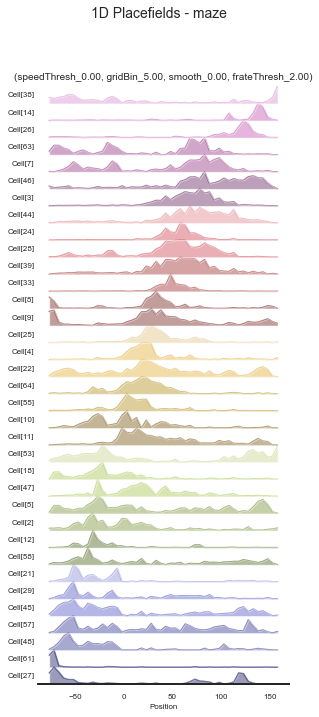

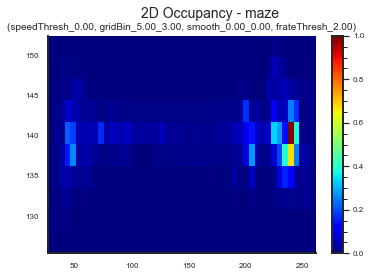

TypeError: cannot unpack non-iterable NoneType object

<Figure size 2160x2160 with 40 Axes>

In [191]:
ax_pf_1D, occupancy_fig, active_pf_2D_figures = plot_all_placefields(active_epoch_placefields1D, active_epoch_placefields2D, active_config)

Saving 1D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.00\pf1D-Placefield1D-maze-speedThresh_0.00-gridBin_5.00-smooth_0.00-frateThresh_2.png"...	 done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.00\pf2D-Occupancy -maze-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.png"...	 done.


C:\Users\Pho\repos\NeuroPy\neuropy\analyses\placefields.py:309: RuntimeWarning: invalid value encountered in true_divide
  # # Original way:


Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.00\pf2D-Placefields-maze-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.png"...	 done.


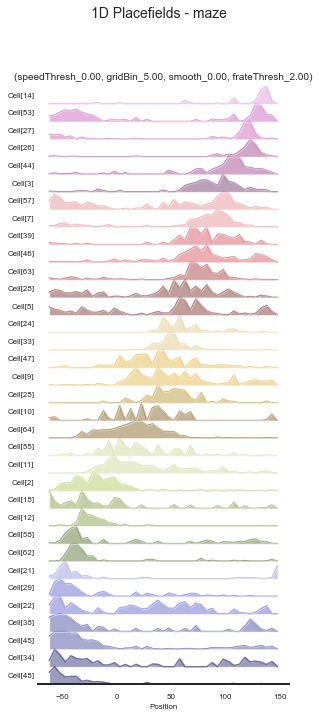

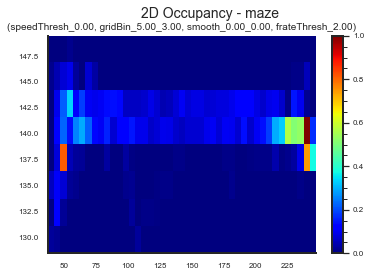

TypeError: cannot unpack non-iterable NoneType object

<Figure size 2160x2160 with 38 Axes>

In [192]:
# from neuropy.plotting.placemaps import plot_all_placefields, plot_placefield_occupancy, plot_occupancy_1D

# plot_occupancy_1D(even_lap_specific_placefields1D, True)
# plot_occupancy_1D(even_lap_specific_placefields1D, False)
# plot_placefield_occupancy(even_lap_specific_placefields2D)

# # fig = plt.Figure()
# fig, axs = plt.subplots(3, 1, figsize=(7, 15))

# # even_lap_specific_placefields1D.occupancy.
# # even_lap_specific_placefields1D.ratemap.xbin_centers
# # np.shape(even_lap_specific_placefields1D.ratemap.xbin) # (214,)
# # even_lap_specific_placefields1D.config.grid_bin_1D # 1
# # np.shape(even_lap_specific_placefields1D.ratemap.xbin_centers) # 213

even_lap_specific_ax_pf_1D, even_lap_specific_occupancy_fig, even_lap_specific_active_pf_2D_figures = plot_all_placefields(even_lap_specific_placefields1D, even_lap_specific_placefields2D, active_config)

# even_lap_specific_placefields1D.plot_ratemaps();
# even_lap_specific_placefields1D.plot_ratemaps()

Saving 1D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.00\pf1D-Placefield1D-maze-speedThresh_0.00-gridBin_5.00-smooth_0.00-frateThresh_2.png"...	 done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.00\pf2D-Occupancy -maze-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.png"...	 done.


C:\Users\Pho\repos\NeuroPy\neuropy\analyses\placefields.py:309: RuntimeWarning: invalid value encountered in true_divide
  # # Original way:


Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze\speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.00\pf2D-Placefields-maze-speedThresh_0.00-gridBin_5.00_3.00-smooth_0.00_0.00-frateThresh_2.png"...	 done.


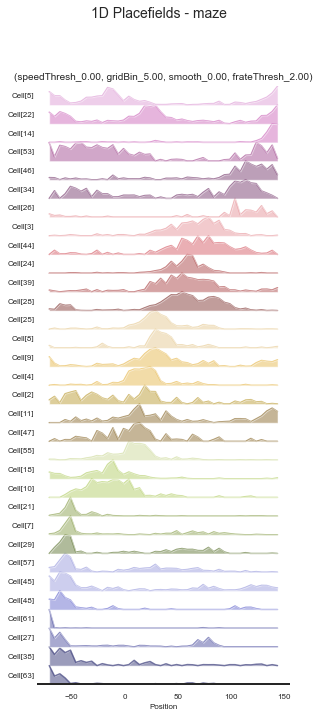

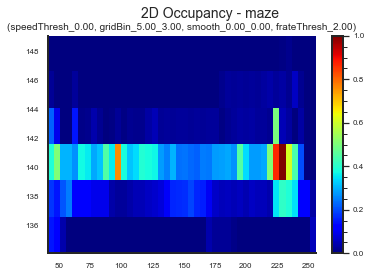

TypeError: cannot unpack non-iterable NoneType object

<Figure size 2160x2160 with 39 Axes>

In [193]:
odd_lap_specific_ax_pf_1D, odd_lap_specific_occupancy_fig, odd_lap_specific_active_pf_2D_figures = plot_all_placefields(odd_lap_specific_placefields1D, odd_lap_specific_placefields2D, active_config)

# Pho Custom Placefield2D Implementation:


In [ ]:
from neuropy.analyses.placefields import _bin_pos, plot_placefield_occupancy, plot_occupancy_custom, _filter_by_frate, Pf2D, _normalized_occupancy

from neuropy.core.ratemap import Ratemap

# First, interested in answering the question "where did the animal spend its time on the track" to assess the relative frequency of events that occur in a given region. If the animal spends a lot of time in a certain region,
# it's more likely that any cell, not just the ones that hold it as a valid place field, will fire there.
    # this can be done by either binning (lumping close position points together based on a standardized grid), neighborhooding, or continuous smearing. 

def build_customPf2D_fromConfig(active_epoch_session, custom_computation_config):
    # num_bins = (10, 10)
    fig = Figure(figsize=(10, 6))
    ax = fig.subplots(2, 1)
    
    should_plot_multiple_occupancy_curves = False
    
    pos_df = active_epoch_session.position.to_dataframe().copy()
    laps_df = active_epoch_session.laps.to_dataframe().copy()
    spk_df = active_epoch_session.spikes_df.copy()

    ## Binning with Fixed Number of Bins:    
    xbin, ybin, bin_info = _bin_pos(pos_df.x.to_numpy(), pos_df.y.to_numpy(), bin_size=custom_computation_config.grid_bin) # bin_size mode
    # print(bin_info)
    ## Binning with Fixed Bin Sizes:
    # xbin, ybin, bin_info = _bin_pos(pos_df.x.to_numpy(), pos_df.y.to_numpy(), num_bins=num_bins) # num_bins mode
    # print(bin_info)

    # print('xbin: {}'.format(xbin))
    # print('ybin: {}'.format(ybin))

    # # Laps plotting:
    # # pos_df.lin_pos.plot();
    # curr_lap_id = 3
    # plt.plot(pos_df.t, pos_df.lin_pos, '*');
    # plt.xlim([laps_df.start[curr_lap_id], laps_df.stop[curr_lap_id]])
    # # pos_df.describe()
    # # pos_df.boxplot()

    raw_occupancy, xedges, yedges = Pf2D._compute_occupancy(pos_df.x.to_numpy(), pos_df.y.to_numpy(), xbin, ybin, active_epoch_session.position.sampling_rate, custom_computation_config.smooth, should_return_raw_occupancy=True)
    seconds_occupancy, normalized_occupancy = _normalized_occupancy(raw_occupancy, position_srate=active_epoch_session.position.sampling_rate)
    occupancy = seconds_occupancy
    # print(np.shape(occupancy))
    # print(occupancy)
    # plot_occupancy(occupancy)
    # plot_occupancy_custom(active_epoch_placefields2D)

    if should_plot_multiple_occupancy_curves:
        fig, ax = plot_occupancy_custom(raw_occupancy, xedges, yedges, max_normalized=False)
        ax.set_title('Custom Occupancy: Raw')
        fig, ax = plot_occupancy_custom(normalized_occupancy, xedges, yedges, max_normalized=False)
        ax.set_title('Custom Occupancy: Normalized')
        fig, ax = plot_occupancy_custom(seconds_occupancy, xedges, yedges, max_normalized=False)
        ax.set_title('Custom Occupancy: Seconds')

    # pos_df.groupby('lap').plas.hist(alpha=0.4)

    # Given a cell's last several seconds of its instantaneous firing rate at a given point in time, what's like likelihood that it's at a given position.
        # continuous position used.

    # spk_df_filtered_speed_thresh = spk_df[spk_df['speed'] >= custom_computation_config.speed_thresh].copy() # filter out the spikes below the speed_threshold
    # spk_x = spk_df_filtered_speed_thresh['x'].to_numpy()
    # spk_y = spk_df_filtered_speed_thresh['y'].to_numpy()

    spk_x = spk_df['x'].to_numpy()
    spk_y = spk_df['y'].to_numpy()
    num_spike_counts_map = Pf2D._compute_tuning_map(spk_x, spk_y, xbin, ybin, occupancy, custom_computation_config.smooth, should_return_raw_tuning_map=True)
    fig, ax[0] = plot_occupancy_custom(num_spike_counts_map, xbin, ybin, max_normalized=False, fig=fig, ax=ax[0])
    ax[0].set_title('Custom num_spike_counts_map: All Neurons')

    mpl_pane = pn.pane.Matplotlib(fig, dpi=144, height=800)
    tabs = pn.Tabs(('num_spike_counts_map', fig))
    ## This seems to be wrong, the highest spike rate is like 0.1 (in Hz)
    spike_rate_Hz_map = num_spike_counts_map / seconds_occupancy
    fig, ax[1] = plot_occupancy_custom(spike_rate_Hz_map, xbin, ybin, max_normalized=False, fig=fig, ax=ax[1])
    ax[1].set_title('Custom spike_rate_Hz_map [Hz]: All Neurons, Occupancy Divided')
    # Add a tab
    tabs.append(('spike_rate_Hz_map', fig))

    # # Add a tab
    # tabs.append(('Slider', pn.widgets.FloatSlider()))

    neuron_split_spike_dfs = [spk_df.groupby('aclu').get_group(neuron_id)[['t','x','y','lin_pos']] for neuron_id in active_epoch_session.neuron_ids] # dataframes split for each ID:
    raw_tuning_maps = np.asarray([Pf2D._compute_tuning_map(neuron_split_spike_dfs[i].x.to_numpy(), neuron_split_spike_dfs[i].y.to_numpy(), xbin, ybin, occupancy, custom_computation_config.smooth, should_return_raw_tuning_map=True) for i in np.arange(len(neuron_split_spike_dfs))]) # dataframes split for each ID:
    tuning_maps = np.asarray([raw_tuning_maps[i] / occupancy for i in np.arange(len(raw_tuning_maps))])
    ratemap = Ratemap(tuning_maps, xbin=xbin, ybin=ybin, neuron_ids=active_epoch_session.neuron_ids)

    # fig, ax = plot_occupancy_custom(raw_tuning_maps[0], xedges, yedges, max_normalized=False)
    # ax.set_title('Custom raw_tuning_maps: Seconds')
    firing_spike_counts_max = np.asarray([np.nanmax(raw_tuning_maps[i]) for i in np.arange(len(neuron_split_spike_dfs))]) # dataframes split for each ID:
    # print('firing_spike_counts_max: {}'.format(firing_spike_counts_max))
    firing_rate_max = np.asarray([np.nanmax(tuning_maps[i]) for i in np.arange(len(neuron_split_spike_dfs))]) # dataframes split for each ID:
    # print('firing_rate_max: {}'.format(firing_rate_max))

    filtered_tuning_maps, filter_function = _filter_by_frate(tuning_maps.copy(), custom_computation_config.frate_thresh)
    filtered_ratemap = Ratemap(filtered_tuning_maps, xbin=xbin, ybin=ybin, neuron_ids=filter_function(ratemap.neuron_ids))
    
    # outputs: filtered_ratemap, filtered_ratemap
    
    # plt.fastcolor(active_epoch_placefields1D.occupancy)
    # Convolve the location data

    # plot_occupancy(active_epoch_placefields2D)
    # pn.pane.Matplotlib(fig)
    
    return fig

def build_customPf2D(active_epoch_session, speed_thresh=1, grid_bin=(10, 3), smooth=(0.0, 0.0), frate_thresh=0.0):
    # custom_active_config = active_config
    # note the second smoothing paramter affects the horizontal axis on the occupancy plot:
    # custom_computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(2, 0.1), frate_thresh=0.0)
    # custom_computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.0, 0.0), frate_thresh=0.0)
    custom_computation_config = PlacefieldComputationParameters(speed_thresh=speed_thresh, grid_bin=grid_bin, smooth=smooth, frate_thresh=frate_thresh)
    return build_customPf2D_fromConfig(active_epoch_session, custom_computation_config)

def build_customPf2D_separate(active_epoch_session, speed_thresh=1, grid_bin_x=10, grid_bin_y=3, smooth_x=0.0, smooth_y=0.0, frate_thresh=0.0):
    return build_customPf2D(active_epoch_session, speed_thresh=speed_thresh, grid_bin=(grid_bin_x, grid_bin_y), smooth=(smooth_x, smooth_y), frate_thresh=frate_thresh)


# build_customPf2D(active_epoch_session, speed_thresh=1, grid_bin=10, smooth=0.0, frate_thresh=0.0)
# pn.interact(build_customPf2D, active_epoch_session=fixed(active_epoch_session), speed_thresh=1, grid_bin=(10, 3), smooth=(0.0, 0.0), frate_thresh=2.0)
pn.interact(build_customPf2D_separate, active_epoch_session=fixed(active_epoch_session), speed_thresh=(0.0, 20.0, 1.0), grid_bin_x=(0.10, 20.0, 0.5), grid_bin_y=(0.10, 20.0, 0.5), smooth_x=(0.0, 20.0, 0.25), smooth_y=(0.0, 20.0, 0.25), frate_thresh=(0.0, 20.0, 1.0))

In [ ]:
# print(np.unique(spk_df['aclu']))
# print(np.unique(spk_df['unit_id']))

curr_unit_idx = 3
def plot_ratemap(curr_unit_idx = 3):
    fig = Figure(figsize=(10, 6))
    ax = fig.subplots()
    mesh_X, mesh_Y = np.meshgrid(ratemap.xbin, ratemap.ybin)
    pfmap = ratemap.tuning_curves[curr_unit_idx]
    curr_pfmap = np.array(pfmap)
    curr_pfmap = np.rot90(np.fliplr(curr_pfmap)) / np.nanmax(curr_pfmap)
    ax.pcolormesh(mesh_X, mesh_Y, curr_pfmap, cmap='jet', vmin=0);
    ax.set_title(f'TuningCurve[{curr_unit_idx}]')
    pn.pane.Matplotlib(fig)
    return fig

# plot_ratemap(5)
# pn.interact(plot_ratemap, curr_unit_idx=3)
pn.interact(plot_ratemap, curr_unit_idx=widgets.IntSlider(start=0,end=ratemap.n_neurons,step=1,value=10))



## Main Spike/Placemap plotting:

# 2D Lap Plotting

### 2D Lap Trajectories Visualization:

## 2D Placefield Plotting:

In [ ]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
from PhoPositionalData.plotting.placefield import plot_1d_placecell_validations
# out_figures_list = plot_1d_placecell_validations(active_epoch_placefields1D, active_config.plotting_config, should_save=True, save_mode='pdf')
out_figures_list = plot_1d_placecell_validations(active_epoch_placefields1D, active_config.plotting_config, should_save=True, save_mode='separate_files')
# plot_1d_placecell_validations(active_epoch_placefields1D, active_config.plotting_config, modifier_string='lap_only', should_save=False)

In [ ]:
out_figures_list = plot_1d_placecell_validations(even_lap_specific_placefields1D, active_config.plotting_config, should_save=False, save_mode='separate_files')

In [ ]:
# active_epoch_placefields2D.plotRaw()
curr_cell_id = 1
fig, ax = active_epoch_placefields2D.plotRaw_v_time(curr_cell_id)
# ax[0].plot(t_both, x_both, 'k', alpha=0.8, linewidth=5)
ax[0].plot(t_even, x_even, 'g', alpha=0.3, linewidth=3)
ax[0].plot(t_odd, x_odd, 'r', alpha=0.3, linewidth=3)

In [ ]:
position_obj = sess.position
# position_obj.dt
position_obj.compute_higher_order_derivatives()
pos_df = position_obj.compute_smoothed_position_info(N=20) ## Smooth the velocity curve to apply meaningful logic to it
pos_df = position_obj.to_dataframe()
pos_df


custom_test_laps = deepcopy(sess.laps)
# custom_test_laps.to_dataframe()

spikes_df = deepcopy(sess.spikes_df)
spikes_df

# any_position_columns = position_obj.dim_columns + position_obj.dim_computed_columns # ['x', 'y', 'velocity_x', 'acceleration_x', 'velocity_y', 'acceleration_y']
# # any_position_columns.append(position_obj.dim_computed_columns)
# any_position_columns

In [ ]:
## Uses Diba-computed Lap information that was loaded from file.

# For Gradient Line Plotting:
# import matplotlib.collections as mcoll
from PhoPositionalData.plotting.laps import _plot_helper_add_span_where_ranges
from PhoPositionalData.plotting.laps import plot_position_curves_figure, _plot_helper_render_laps

## non-pre-filtered version, also doesn't create a duplicate dataframe:
pos_df_is_nonNaN_lap = np.logical_not(np.isnan(pos_df.lap))
pos_df_is_even_lap = np.logical_and(pos_df_is_nonNaN_lap, (np.remainder(pos_df.lap, 2) == 0))
pos_df_is_odd_lap = np.logical_and(pos_df_is_nonNaN_lap, (np.remainder(pos_df.lap, 2) != 0))


## pre-filtered copy version:
# pos_df should already have the 'lap' column, so this should be easy:
good_pos_df = pos_df[pos_df_is_nonNaN_lap] # pre-filter for non-NaN laps. Throws an error otherwise.
unique_lap_values, lap_grouped_pos_dfs = partition(good_pos_df, 'lap') # split position dataframe based on its lap number
# lap_num_points = [np.shape(a_df) for a_df in lap_grouped_pos_dfs]
# lap_points = [a_df[curr_lap_i][['t','x']].to_numpy() for a_df in lap_grouped_pos_dfs]
is_even_lap = np.remainder(unique_lap_values, 2) == 0
is_odd_lap = np.logical_not(is_even_lap)


# Easy way to get the even/odd a.k.a forward/reverse direction laps:
unique_lap_dir_values, lap_dir_grouped_pos_dfs = partition(good_pos_df, 'lap_dir') # split position dataframe based on its lap number
unique_lap_dir_values

## equivalence testing:
# np.shape(pos_df[pos_df_is_even_lap]) # (41331, 12)
# np.shape(pd.concat(lap_grouped_pos_dfs[is_even_lap])) # (41331, 12)
assert (np.shape(pos_df[pos_df_is_even_lap]) == np.shape(pd.concat(lap_grouped_pos_dfs[is_even_lap]))), 'Must be same size'

# np.shape(pos_df[pos_df_is_odd_lap]) # (16023, 12)
assert (np.shape(pos_df[pos_df_is_odd_lap]) == np.shape(pd.concat(lap_grouped_pos_dfs[is_odd_lap]))), 'Must be same size'


# pos_df[pos_df_is_odd_lap]
# lap_points = [a_df[curr_lap_i][['t','x']].to_numpy() for a_df in lap_grouped_pos_dfs]
# curr_lap_num_points

In [ ]:
## Plot Extant Laps Variable:
fig, out_axes_list = plot_position_curves_figure(position_obj, include_velocity=True, include_accel=False, figsize=(24, 10))

## lap_grouped_pos_dfs concatenation-based version:
curr_even_lap_dir_points = pos_df[pos_df_is_even_lap][['t','x']].to_numpy()
out_axes_list[0].scatter(curr_even_lap_dir_points[:,0], curr_even_lap_dir_points[:,1], s=0.5, c='g')

curr_odd_lap_dir_points = pos_df[pos_df_is_odd_lap][['t','x']].to_numpy()
out_axes_list[0].scatter(curr_odd_lap_dir_points[:,0], curr_odd_lap_dir_points[:,1], s=0.5, c='r')


## Span_where implementation:
# Draws colored spans indicating the lap that is active during a given time interval.

# _add_span_where_ranges(pos_df.t.to_numpy(), pos_df_is_even_lap, pos_df_is_odd_lap, ax0)
# _add_span_where_ranges(pos_df.t.to_numpy(), pos_df_is_even_lap, pos_df_is_odd_lap, ax1)
# _add_span_where_ranges(pos_df.t.to_numpy(), pos_df_is_even_lap, pos_df_is_odd_lap, ax2)


## Constain to a specific lap:
# curr_lap_times = sess.laps.get_lap_times(2)
# out_axes_list[0].set_xlim([curr_lap_times[0], curr_lap_times[-1]])
# out_axes_list[0].set_xlim([250.0, 300.0])

In [ ]:
# Now try a velocity threshold based lap detection mechanism:
import matplotlib.collections as mcoll

    
    
# plateaus:

# ## Platform[0]:
# collection = mcoll.BrokenBarHCollection.span_where(pos_df.t.to_numpy(), ymin=curr_span_ymin, ymax=curr_span_ymax, where=(pos_df['x'] < 63.5), facecolor='red', alpha=0.25)
# curr_ax.add_collection(collection)
# ## Platform[1]:
# collection = mcoll.BrokenBarHCollection.span_where(pos_df.t.to_numpy(), ymin=curr_span_ymin, ymax=curr_span_ymax, where=(pos_df['x'] > 223.9), facecolor='orange', alpha=0.25)
# curr_ax.add_collection(collection)

# fig, out_axes_list = plot_position_curves_figure(position_obj, include_velocity=True, include_accel=False)

desc_crossing_beginings, desc_crossing_midpoints, desc_crossing_endings, asc_crossing_beginings, asc_crossing_midpoints, asc_crossing_endings = estimate_laps(pos_df)
custom_test_laps_obj = Laps.from_estimated_laps(pos_df['t'].to_numpy(), desc_crossing_beginings, desc_crossing_endings, asc_crossing_beginings, asc_crossing_endings)
## Determine the spikes included with each computed lap:
custom_test_laps_obj = compute_laps_spike_indicies(custom_test_laps_obj, spikes_df)


# backup the extant laps object to prepare for the new one:
sess.old_laps_obj = deepcopy(sess.laps)
# sess.old_laps_obj
sess.laps = deepcopy(custom_test_laps_obj) # replace the laps obj
sess.laps.to_dataframe()

# plot_laps_2d(sess, legacy_plotting_mode=True)
plot_laps_2d(sess, legacy_plotting_mode=False)

In [ ]:
# def _plot_helper_render_estimated_laps(desc_crossing_beginings, desc_crossing_midpoints, desc_crossing_endings, asc_crossing_beginings, asc_crossing_midpoints, asc_crossing_endings):

## Working Midpoint Detection:
# Plots the midpoints as red and green dots on the pos_x curve
fig, out_axes_list = plot_position_curves_figure(position_obj, include_velocity=False, include_accel=False)
out_axes_list[0].set_ylim([np.nanmin(position_obj.x), np.nanmax(position_obj.x)])
_plot_helper_render_lap(pos_df['t'].to_numpy(), pos_df['x'].to_numpy(), desc_crossing_beginings, desc_crossing_midpoints, desc_crossing_endings, color='r', ax=out_axes_list[0])
_plot_helper_render_lap(pos_df['t'].to_numpy(), pos_df['x'].to_numpy(), asc_crossing_beginings, asc_crossing_midpoints, asc_crossing_endings, color='g', ax=out_axes_list[0])
# ax0.set_xlim([240.0, 500.0])

In [ ]:
active_epoch_placefields2D.plotMap(figsize=(12,20), enable_spike_overlay=True)

In [ ]:
from PhoPositionalData.plotting.laps import plot_lap_trajectories_2d
fig, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=len(sess.laps.lap_id), active_page_index=0)
fig.suptitle('Lap Trajectories 2D', fontsize=22)
# fig_out_path = active_config.plotting_config.get_figure_save_path('lap_trajectories_2D').with_suffix('.png')
# fig.savefig(fig_out_path)
plt.show()

# p, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=22, active_page_index=0)
# p, axs, laps_pages = plot_lap_trajectories_2d(sess, curr_num_subplots=22, active_page_index=1)

# 3D Plots

### 3D Lap Trajectories Visualization:

In [ ]:
from PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
p, laps_pages = plot_lap_trajectories_3d(sess, curr_num_subplots=10, active_page_index=1)
p.show()

## Tuning Curves 3D Plot:

In [ ]:
from PhoGui.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
try: pActiveTuningCurvesPlotter
except NameError: pActiveTuningCurvesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipcDataExplorer = InteractivePlaceCellTuningCurvesDataExplorer(active_config, active_epoch_session, active_epoch_placefields, active_config.plotting_config.pf_colors, extant_plotter=pActiveTuningCurvesPlotter)
pActiveTuningCurvesPlotter = ipcDataExplorer.plot(pActiveTuningCurvesPlotter) # [2, 17449]

### Tuning-Curve Height Spikes Plot Testing:

In [ ]:
from matplotlib.collections import EventCollection
from scipy.interpolate import RectBivariateSpline # for 2D spline interpolation

## Getting the proper z-position for the tuning curve:
# Create source to ray trace
sphere = pv.Sphere(radius=0.85)

# Define a list of origin points and a list of direction vectors for each ray
# vectors = [ [cos(radians(x)), sin(radians(x)), 0] for x in range(0, 360, 5)]

# origins = [[0, 0, 0]] * len(active_lap_specific_epoch_session.spikes_df['x'])
# origins = np.hstack(active_lap_specific_epoch_session.spikes_df[['x','y']].to_numpy().T, np.full_like(active_lap_specific_epoch_session.spikes_df['x'].to_numpy(), 0.0))
# origins[0,:]
# spike_series_identities = active_flattened_spike_identities # currently unused

active_epoch_placefields2D


active_epoch_placefields1D.ratemap_spiketrains # times where the spikes occured.
active_epoch_placefields1D.ratemap_spiketrains_pos # position where the spikes occured.

## This is the correct 1D interpolation! It gets the y-values on the curve where the spikes could be plot!
spike_pf_heights_1D = [np.interp(active_epoch_placefields1D.spk_pos[i], active_epoch_placefields1D.ratemap.xbin_centers, active_epoch_placefields1D.ratemap.normalized_tuning_curves[i]) for i in np.arange(active_epoch_placefields1D.ratemap.n_neurons)] # the appropriately interpolated values for where the spikes should be on the tuning_curve

## Potentially successfully implemented the z-interpolation!!!: 2D interpolation where the (x,y) point of each spike is evaluated to determine the Z-position it would correspond to on the pf map.
_spike_pf_heights_2D_splineAproximator = [RectBivariateSpline(active_epoch_placefields2D.ratemap.xbin_centers, active_epoch_placefields2D.ratemap.ybin_centers, active_epoch_placefields2D.ratemap.normalized_tuning_curves[i]) for i in np.arange(active_epoch_placefields2D.ratemap.n_neurons)] 
spike_pf_heights_2D = [spike_pf_heights_2D_splineAproximator[i](active_epoch_placefields2D.spk_pos[i][0], active_epoch_placefields2D.spk_pos[i][1], grid=False) for i in np.arange(active_epoch_placefields1D.ratemap.n_neurons)] # the appropriately interpolated values for where the spikes should be on the tuning_curve
print(f'np.shape(spike_pf_heights_2D): {np.shape(spike_pf_heights_2D[i])}') # (809,)

#spike_pf_heights_1D is (814,) and the values range between 0.0 and 1.0

fig = plt.Figure()
axes = fig.subplots(3, 1, sharex=True)
axes[0].plot(active_epoch_placefields1D.ratemap.xbin_centers, active_epoch_placefields1D.ratemap.normalized_tuning_curves[i])
axes[0].set_ylabel('norm_tuning_curve')
# axes[0].plot(active_epoch_placefields1D.ratemap.xbin_centers, active_epoch_placefields1D.ratemap.normalized_tuning_curves[i])
# plt.plot(active_epoch_placefields1D.spk_pos[i])
# plt.plot(active_epoch_placefields1D.spk_t[i], spike_pf_heights_1D[i])

axes[1].scatter(active_epoch_placefields1D.spk_pos[i], spike_pf_heights_1D[i])
axes[1].set_ylabel('spike_pf_heights')

# # create the events marking the x data points
# xevents1 = EventCollection(xdata1, color='tab:blue', linelength=0.05)
# xevents2 = EventCollection(xdata2, color='tab:orange', linelength=0.05)

# # create the events marking the y data points
# yevents1 = EventCollection(ydata1, color='tab:blue', linelength=0.05,
#                            orientation='vertical')
# yevents2 = EventCollection(ydata2, color='tab:orange', linelength=0.05,
#                            orientation='vertical')

# # add the events to the axis
# ax.add_collection(xevents1)
# ax.add_collection(xevents2)
# ax.add_collection(yevents1)
# ax.add_collection(yevents2)

fig

In [ ]:
active_epoch_session.position

vectors = [[0, 0, 10.0]] * len(active_lap_specific_epoch_session.spikes_df['x']) # just up in the z-direction
spike_series_positions = active_lap_specific_epoch_session.spikes_df[['x','y']].to_numpy().T    
z_fixed = np.full_like(spike_series_positions[0,:], 1.1) # Offset a little bit in the z-direction so we can see it
origins = np.vstack((spike_series_positions[0,:], spike_series_positions[1,:], z_fixed)).T
# origins

# Perform ray trace
# Define line segment
# start = [0, 0, 0]
# stop = [0.25, 1, 0.5]

curr_idx = 0
curr_tuning_curve_mesh = ipcDataExplorer.plots['tuningCurvePlotActors'][curr_idx]
start = origins[curr_idx]
stop = start + vectors[curr_idx]

# Perform ray trace
# points, ind = sphere.ray_trace(start, stop)
points, ind = curr_tuning_curve_mesh.ray_trace(start, stop)
pActiveTuningCurvesPlotter.add_mesh(ray, color="blue", line_width=5, name='test_ray', label="Ray Segment")
pActiveTuningCurvesPlotter.add_mesh(intersection, color="maroon",
           point_size=25, label="Intersection Points", name='test_ray_intersection')
# points, ind_ray, ind_tri = sphere.multi_ray_trace(origins, vectors)

## Interactive 3D Spike and Behavior Browser: 

In [ ]:
import PhoGui
from PhoGui.InteractivePlotter.PhoInteractivePlotter import PhoInteractivePlotter
from PhoGui.InteractivePlotter.shared_helpers import InteractivePyvistaPlotterBuildIfNeededMixin
from PhoGui.InteractivePlotter.InteractivePlaceCellDataExplorer import InteractivePlaceCellDataExplorer

active_config.plotting_config.show_legend = True

try: pActiveInteractivePlaceSpikesPlotter
except NameError: pActiveInteractivePlaceSpikesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipspikesDataExplorer = InteractivePlaceCellDataExplorer(active_config, active_epoch_session, extant_plotter=pActiveInteractivePlaceSpikesPlotter)
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)

## CustomDataExplorer 3D Plotter:

In [ ]:
from PhoGui.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer
active_laps_config = InteractivePlaceCellConfig(active_session_config=sess.config, active_epochs=None, video_output_config=None, plotting_config=None) # '3|1    
active_laps_config.plotting_config = PlottingConfig(output_subplots_shape='1|5', output_parent_dir=Path('output', sess.config.session_name, 'custom_laps'))

try: pActiveInteractiveLapsPlotter
except NameError: pActiveInteractiveLapsPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
iplapsDataExplorer = InteractiveCustomDataExplorer(active_laps_config, sess, extant_plotter=pActiveInteractiveLapsPlotter)
pActiveInteractiveLapsPlotter = iplapsDataExplorer.plot(pActivePlotter=pActiveInteractiveLapsPlotter)

In [ ]:
len(sess.laps.lap_id) # 44

In [ ]:
for i in np.arange(len(sess.laps.lap_id)):
    curr_lap_id = sess.laps.lap_id[i]
    curr_lap_t_start, curr_lap_t_stop = sess.laps.get_lap_times(i)
    curr_lap_position_traces = laps_position_traces[i]
    plot_lap_trajectory_path_spline(iplapsDataExplorer, curr_lap_position_traces, curr_lap_id)

In [ ]:
# p = pv.Plotter(shape=(5, 1), border=True)
p = pActiveInteractiveLapsPlotter
num_laps_to_show = len(sess.laps.lap_id)
num_laps_to_show = 5
flat_lap_id_index = np.arange(len(sess.laps.lap_id))
# subplot_lap_id_index = np.reshape([4,11])
for i in np.arange(num_laps_to_show):
    curr_lap_id = sess.laps.lap_id[i]
    p.subplot(i, 0)
    # curr_lap_t_start, curr_lap_t_stop = sess.laps.get_lap_times(i)
    plot_lap_trajectory_path_spline(iplapsDataExplorer, laps_position_traces[i], curr_lap_id)
    
p.link_views()  # link all the views
p.show()

In [ ]:
# def plot_placefields2D(pTuningCurves, active_placefields, pf_colors: np.ndarray, zScalingFactor=10.0, show_legend=False):

#     # .threshold().elevation()

#     curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves
#     # curr_tuning_curves[curr_tuning_curves < 0.1] = np.nan
#     curr_tuning_curves = curr_tuning_curves * zScalingFactor

#     num_curr_tuning_curves = len(curr_tuning_curves)
#     # Get the cell IDs that have a good place field mapping:
#     good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
#     tuningCurvePlot_x, tuningCurvePlot_y = np.meshgrid(active_placefields.ratemap.xbin_centers, active_placefields.ratemap.ybin_centers)

#     pdata_currActiveNeuronTuningCurve = pv.StructuredGrid(tuningCurvePlot_x, tuningCurvePlot_y, curr_active_neuron_tuning_Curve)
#     pdata_currActiveNeuronTuningCurve["Elevation"] = curr_active_neuron_tuning_Curve.ravel(order="F")
        
#     return pTuningCurves

# plot_placefields2D(pTuningCurves, active_epoch_placefields

# ipcDataExplorer.plots['spikes_pf_active']['cellID']

# only_active_colormap = ipcDataExplorer.active_config.plotting_config.active_cells_listed_colormap.copy()
# only_active_colormap
test_full_pc_data = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc']

# test_subset = test_full_pc_data.GetCellGhostArray()
# test_subset = test_full_pc_data.GetCellData() # vtkmodules.vtkCommonDataModel.vtkCellData
# test_subset = test_full_pc_data[test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData

# test_subset = test_full_pc_data.GetGhostArray() # [test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData


unique_ids = np.unique(test_full_pc_data['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# count_arr = np.bincount(test_full_pc_data['cellID'])
count_arr
# array([ 3591,  3311,   231,  4410,     0,   910,     0,  4417,     0,
#         1050,  2443,     0,     0,     0,     0,  2156,  6664,     0,
#            0, 10052,  6286,  2394,  1561,     0,     0,  8827,  4788,
#         6412,     0,     0,     0,   959,  2051,     0,     0,     0,
#         4809,  2758,     0,     0,  1575,     0,  3465, 14861,  2212,
#          777,  2772,     0,     0,     0,     0,  3206,     0,  4032,
#            0,  6489,  2674], dtype=int64)

# good_placefield_neuronIDs: [  5   8  10  13  14  16  19  21  23  25  28  31  32  33  36  37  41  49
#   52  53  54  55  57  59  60  61  62  63  64  66  68  69  74  75  76  78
#   83  86  88  89  90  92  96  98 105 108]; (46 good)

# 1, 4, 6, 7, 8, 11, 18, 19, 21 ## CONCLUSION: the ones that work are indeed the non-zero entries, but the checkboxes work in reverse order to this array that's printed. Meaning you start at the end and work back.
# len(count_arr) # 107
print(unique_ids) # [  3   6   8  11  12  14  17  19  21  23  26  29  30  31  34  35  39  47
  # 50  51  52  53  55  57  58  59  60  61  62  64  66  67  72  73  74  76
  # 81  84  86  87  88  90  94  96 103 106]


# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['aclu'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['aclu'].values)
# print('active_epoch_session.spikes_df unique aclu values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique aclu value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 
# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['unit_id'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'].values)
# print('active_epoch_session.spikes_df unique unit_id values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique unit_id value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 

In [ ]:
# pActiveTuningCurvesPlotter.export_obj('export.obj')
# pActiveTuningCurvesPlotter.export_gltf('export.gltf')

ipcDataExplorer.update_placefield_spike_visibility([38], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([44, 53], True) # seems to work

# test_subset
# test_subset

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53, 44], False) # seems to work

In [ ]:
ipcDataExplorer.gui['tuningCurveSpikeVisibilityCallbacks'][1](False)
# ipcDataExplorer.get_cell_index([2, 3])

In [ ]:
mesh = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc'].cast_to_unstructured_grid()
# mesh.n_cells
mesh_unique_ids = np.unique(mesh['cellID'])
print('n_cells: {}'.format(mesh.n_cells)) # 122143
print('cellIDs of mesh: {}'.format(mesh_unique_ids))
# np.unique(mesh['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# ipcDataExplorer.hide_placefield_spikes([0,1,2,3], should_invert=True)
# ipcDataExplorer.hide_placefield_spikes([23,2,34], should_invert=True)

# ipcDataExplorer.hide_placefield_spikes([34], should_invert=True)
ipcDataExplorer.hide_placefield_spikes([38], should_invert=False)

In [ ]:
# the list of spike times that occured for this cell:
i = 2
active_epoch_session.neurons.neuron_ids[i]
active_epoch_session.neurons.spiketrains[i]

# spikes_df = FlattenedSpiketrains.build_spike_dataframe(sess)


In [ ]:
## Timestamp Fixing:
def tt(position_timestamps, t_begin, SampleRate):
    return ((position_timestamps - t_begin) / (1e6 * SampleRate))

# sess.laps.lap_start_stop_flat_idx

sess.recinfo.dat_sampling_rate


# Programmatically change the animal position trail:

In [ ]:
curr_lap_id = int_input.value

# plot_lap_trajectory_path(ipspikesDataExplorer, curr_lap_position_traces)
plot_lap_trajectory_path_spline(ipspikesDataExplorer, curr_lap_position_traces)
# curr_lap_t_start
## TODO: enable showding/hiding the spikes for this data range programmatically in InteractivePlaceCellDataExplorer. 
# ipspikesDataExplorer.
# curr_lap_spike_t_seconds
# curr_lap_spike_indicies
# active_epoch_session.flattened_spiketrains.spikes_df.t_seconds.values[curr_lap_spike_indicies] # index 145937 is out of bounds for axis 0 with size 19647

In [ ]:
# From the laps and position dataframe, extract which lap every position belongs to:

# curr_lap_position_df_is_included = curr_position_df['t'].between(laps_df['start'], laps_df['stop'], inclusive=True) # returns a boolean array indicating inclusion in teh current lap
# curr_lap_position_df = curr_position_df[curr_lap_position_df_is_included] 
# curr_position_df['lap'] = np.NaN

curr_position_df = sess.compute_position_laps()
# curr_position_df.groupby('lap').groups[1] # returns the Int64Index
# curr_position_df.groupby('lap').get_group(2)[['t','x','y','lin_pos']]

lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id]
lap_specific_position_dfs
curr_lap_position_traces = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]
curr_lap_position_traces
curr_lap_time_range = [[lap_pos_df[['t']].to_numpy()[0].item(), lap_pos_df[['t']].to_numpy()[-1].item()] for lap_pos_df in lap_specific_position_dfs]
curr_lap_time_range

In [ ]:
# .GetPosition() returns the actor's position, which is usually (0.0, 0.0, 0.0), and does not relate to the actor's data points
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetPosition()
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetXRange() # (44.23604202270508, 245.9059600830078)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetYRange() # (135.27638244628906, 145.448974609375)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetZRange() # (1.100000023841858, 1.100000023841858)

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
print('curr_animal_point: {}'.format(curr_animal_point))
curr_animal_point # curr_animal_point

# curr_animal_point = np.array([0, 0, 0])

# curr_animal_point = np.column_stack((self.x[active_window_sample_indicies], self.y[active_window_sample_indicies], self.z_fixed))
# ipspikesDataExplorer.on_programmatic_data_update(curr_animal_point=curr_animal_point)

curr_debug_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
ipspikesDataExplorer.perform_plot_location_point('debug_point_plot', curr_animal_point, color='r')

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # not updated
print('new curr_animal_point: {}'.format(curr_animal_point))

In [ ]:
# ipspikesDataExplorer.flattened_spike_positions_list

active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df

In [ ]:
curr_lap_dataframe

In [ ]:
active_epoch_session.time_slice

In [ ]:
## Adding interaction highlighters:
pActiveInteractivePlaceSpikesPlotter.